In [91]:
import torch
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [92]:
words = open("names.txt", 'r').read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [93]:
chars = sorted(set(''.join(words)))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0

itos = {i:s for s,i in stoi.items()}

In [94]:
xs = []
ys = []

# creating trigram dataset
for w in words:
    letters = ['.'] + list(w) + ['.']
    for char1, char2, char3 in zip(letters, letters[1:], letters[2:]):      
        xs.append([stoi[char1], stoi[char2]])
        ys.append(stoi[char3])
        
xs = torch.tensor(xs)
ys = torch.tensor(ys)

In [95]:
print(xs[:10], ys[:10])

tensor([[ 0,  5],
        [ 5, 13],
        [13, 13],
        [13,  1],
        [ 0, 15],
        [15, 12],
        [12,  9],
        [ 9, 22],
        [22,  9],
        [ 9,  1]]) tensor([13, 13,  1,  0, 12,  9, 22,  9,  1,  0])


In [96]:
xs.shape

torch.Size([196113, 2])

In [97]:
# stack vectors to get one starting layer of 54 nodes
x_enc = F.one_hot(xs, num_classes=27).reshape(-1, 54).float()
x_enc.shape

torch.Size([196113, 54])

In [98]:
x_enc[0]

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [99]:
ys.shape

torch.Size([196113])

In [100]:
W = torch.randn((54, 27), requires_grad=True)

In [101]:
# training loop
NUM_ITERS = 200

n = ys.numel()
lr = 10
losses = []

for i in range(NUM_ITERS):
    # forward pass
    logits = x_enc @ W
    counts = torch.exp(logits)
    probs = counts / counts.sum(1, keepdim=True)
    
    # calculate loss
    loss = -probs[torch.arange(ys.numel()), ys].log().mean()
    losses.append(loss.item())
    
    if i % 10 == 0:
        print(loss.item())
    
    # clear gradients
    W.grad = None
    
    # backward pass
    loss.backward()
    
    # gradient update
    W.data -= lr * W.grad

4.130555152893066
3.033756732940674
2.743847370147705
2.6067185401916504
2.5272040367126465
2.475642442703247
2.4396748542785645
2.4131760597229004
2.392824649810791
2.376692295074463
2.3635809421539307
2.3527047634124756
2.3435280323028564
2.3356738090515137
2.3288698196411133
2.32291579246521
2.3176605701446533
2.3129873275756836
2.308805465698242
2.305042266845703


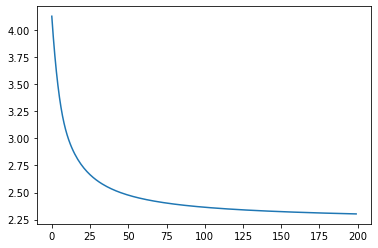

In [102]:
# plotting the losses
plt.plot(np.arange(NUM_ITERS), losses)

#### Notice that the losses converge to a value lower than the bigram model

### Sampling from the Model

In [103]:
NUM_SAMPLES = 100
idx = 0

p_second_letter = torch.tensor(([0] + [1] * 26))/26

for i in range(NUM_SAMPLES):
    out = ''
    
    state = [0, None]
    # uniform sampling of first letter in name
    state[1] = torch.multinomial(p_second_letter, num_samples=1, replacement=True).item()
    state = torch.tensor(state)
    
    out = itos[state[0].item()] + itos[state[1].item()]
        
    while True:
        x_enc_state = F.one_hot(state, num_classes=27).reshape(-1, 54).float()
        logits = x_enc_state @ W
        counts = logits.exp()
        probs = counts / counts.sum(1, keepdim=True)
            
        next_char = torch.multinomial(probs, num_samples=1, replacement=True).item()
        
        if next_char == 0:
            print(out[1:])
            break
        
        # updating state
        state[0] = state[1]
        state[1] = next_char
        
        out += itos[next_char]

prey
qatya
een
ayle
oujto
xengeomyo
wbe
vmaynna
er
fbe
rion
maynn
paligelina
rasstanne
zahwa
srhia
areschilemarialins
kah
lonimarein
gdulen
vadariabrkzellonderayka
tynn
phev
ghanac
el
nrelaelai
ok
faizarcetona
had
von
tynnyegrantado
cahlley
narelleamela
eiya
nexarismidam
wakeh
zud
qullen
haulony
kamol
typanahamikos
vorastmay
cey
bmyana
kemgrtkaydh
mid
via
kiyusta
phaulyan
zbef
saudienn
gottra
qade
wucuz
wmleyss
gayrharlee
uilyna
reahat
jeliahric
zaylealyqnayanilae
seh
isalavdrma
mydis
loa
orivan
bevrisamirayn
ehyarireyann
jayma
viroymi
qra
wlenthie
yuh
sh
zainee
keyah
gan
erich
wande
qomnee
lamkicylo
jani
elgnftoo
ghoudano
gani
kat
elyqbzilylariangcoriy
kyonah
rana
xdusv
fikemtenileshashartynisa
ma
cadenep
syna
ebenmathir
danzan
jaminorissina
eltzusqf
rettion
uenn
raya


In [126]:
# try adding another hidden layer + biases

W1 = torch.randn((54, 27), requires_grad=True)
W2 = torch.randn((27, 27), requires_grad=True)

b1 = torch.randn(27, requires_grad=True)
b2 = torch.randn(27, requires_grad=True)


# training loop
NUM_ITERS = 350

n = ys.numel()
lr = 10
losses = []

for i in range(NUM_ITERS):
    # forward pass
    logits = (((x_enc @ W1) + b1).sigmoid() @ W2) + b2
    
    counts = torch.exp(logits)
    probs = counts / counts.sum(1, keepdim=True)
    
    # calculate loss
    loss = -probs[torch.arange(ys.numel()), ys].log().mean()
    losses.append(loss.item())
    
    if i % 10 == 0:
        print(loss.item())
    
    # clear gradients
    W1.grad = None
    W2.grad = None
    b1.grad = None
    b2.grad = None
    
    # backward pass
    loss.backward()
    
    # gradient update
    W1.data -= lr * W1.grad
    W2.data -= lr * W2.grad
    b1.data -= lr * b1.grad
    b2.data -= lr * b2.grad

6.815441131591797
2.6890361309051514
2.615915298461914
2.5670840740203857
2.5278801918029785
2.4942429065704346
2.4652650356292725
2.440870523452759
2.4205098152160645
2.403381586074829
2.388702869415283
2.375864028930664
2.4050278663635254
2.429809093475342
2.4082629680633545
2.3963258266448975
2.3873565196990967
2.379894733428955
2.373426914215088
2.3676888942718506
2.362514019012451
2.3577895164489746
2.353433609008789
2.349386692047119
2.34560227394104
2.342043876647949
2.3386831283569336
2.335496425628662
2.3324646949768066
2.3295726776123047
2.3268072605133057
2.324157953262329
2.321615695953369
2.3191728591918945
2.3168230056762695


In [125]:
NUM_SAMPLES = 100
idx = 0

p_second_letter = torch.tensor(([0] + [1] * 26))/26

for i in range(NUM_SAMPLES):
    out = ''
    
    state = [0, None]
    # uniform sampling of first letter in name
    state[1] = torch.multinomial(p_second_letter, num_samples=1, replacement=True).item()
    state = torch.tensor(state)
    
    out = itos[state[0].item()] + itos[state[1].item()]
        
    while True:
        x_enc_state = F.one_hot(state, num_classes=27).reshape(-1, 54).float()
        logits = (((x_enc_state @ W1) + b1).sigmoid() @ W2) + b2
        counts = logits.exp()
        probs = counts / counts.sum(1, keepdim=True)
            
        next_char = torch.multinomial(probs, num_samples=1, replacement=True).item()
        
        if next_char == 0:
            print(out[1:])
            break
        
        # updating state
        state[0] = state[1]
        state[1] = next_char
        
        out += itos[next_char]

hark
o
na
ut
xa
ma
ghuy
sun
ach
pe
ra
bahs
ca
vyy
pu
wa
wa
thex
ja
gikotyn
brlay
peau
nva
zen
pho
careyns
mami
na
ra
n
ka
o
ora
jy
nl
za
via
tasya
a
mavcllonan
il
fy
ja
qrcera
zyly
krnbel
sa
curt
da
pa
en
uomigllaks
pra
ir
qdx
som
sa
wo
sorlsis
mhrr
ykiyahia
jatym
n
zozabs
ul
ven
lun
fero
falon
zo
tone
dan
ria
ers
anva
uu
yea
shn
caki
ncil
en
uafkan
emmona
zca
jan
vr
qa
qemdon
qahamrbtry
den
ly
briy
qhal
gra
ra
di
ki
juc
janlla
njlel
